In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

N, D1, D2 = train_data.data.shape
D = D1 * D2
Nc = 10

In [3]:
class Model(nn.Module):
    def __init__(self, D, Nc):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(D, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,Nc),       
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.net(x)
        return logits

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model(D, Nc).to(device)

loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
epochs = 10

perf = {"accuracy":[], "loss":[]}
perf_test = {"accuracy":[], "loss":[]}
for epoch in range(epochs):
    # n_batch = len(train_loader)
    # sz = len(train_loader.dataset)
    # loss_epoch = 0
    # correct_epoch = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_f(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
    correct_epoch = (pred.argmax(dim=1)==y).type(torch.float).sum().item()
    loss_epoch = loss.item()
    correct_epoch /= len(y)
    # loss_epoch /= n_batch
    perf["accuracy"].append(correct_epoch)
    perf["loss"].append(loss_epoch)
    print(f"{epoch}-Train@last batch: loss = {loss_epoch:>.2e}, acc = {correct_epoch:>.2f}")
    
    with torch.no_grad():
        n_batch = len(test_loader)
        sz = len(test_loader.dataset)
        loss_epoch = 0
        correct_epoch = 0
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = loss_f(pred, y)
            correct_epoch += (pred.argmax(1)==y).type(torch.float).sum().item()
            loss_epoch += loss.item()
        correct_epoch /= sz
        loss_epoch /= n_batch
        perf_test["accuracy"].append(correct_epoch)
        perf_test["loss"].append(loss_epoch)
        print(f"{epoch}-Test: loss = {loss_epoch:>.2e}, acc = {correct_epoch:>.2f}")

0-Train@last batch: loss = 2.25e+00, acc = 0.12
0-Test: loss = 2.25e+00, acc = 0.26
1-Train@last batch: loss = 2.13e+00, acc = 0.25
1-Test: loss = 2.13e+00, acc = 0.36
2-Train@last batch: loss = 1.91e+00, acc = 0.34
2-Test: loss = 1.90e+00, acc = 0.49
3-Train@last batch: loss = 1.61e+00, acc = 0.56
3-Test: loss = 1.58e+00, acc = 0.64
4-Train@last batch: loss = 1.36e+00, acc = 0.59
4-Test: loss = 1.32e+00, acc = 0.63
5-Train@last batch: loss = 1.18e+00, acc = 0.59
5-Test: loss = 1.15e+00, acc = 0.64
6-Train@last batch: loss = 1.07e+00, acc = 0.59
6-Test: loss = 1.03e+00, acc = 0.65
7-Train@last batch: loss = 1.00e+00, acc = 0.59
7-Test: loss = 9.49e-01, acc = 0.66
8-Train@last batch: loss = 9.56e-01, acc = 0.66
8-Test: loss = 8.93e-01, acc = 0.67
9-Train@last batch: loss = 9.22e-01, acc = 0.66
9-Test: loss = 8.51e-01, acc = 0.68


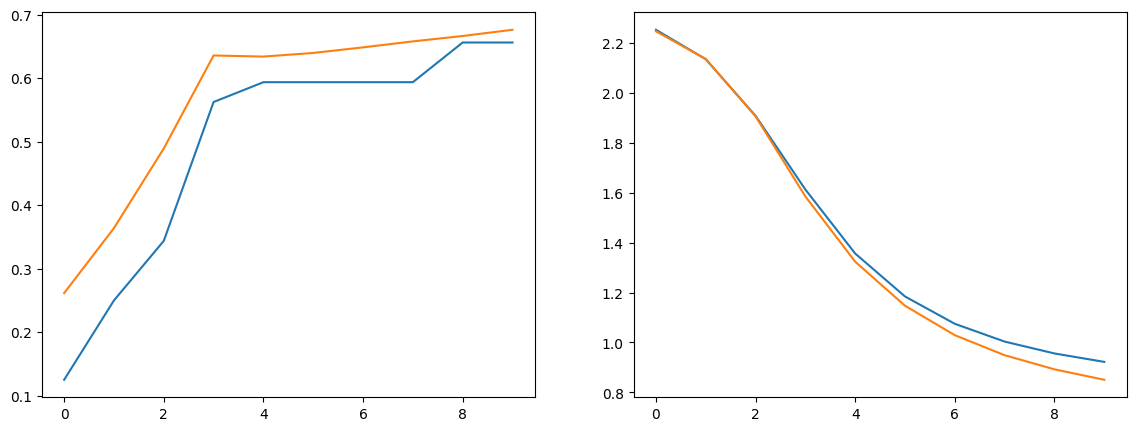

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(perf["accuracy"], label='Train')
plt.plot(perf_test["accuracy"], label='Test')
plt.subplot(1,2,2)
plt.plot(perf["loss"], label="Train")
plt.plot(perf_test["loss"], label="Test")